<a href="https://colab.research.google.com/github/Krishika-Garg/fedlearning-under-attack/blob/main/Minor_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch, torchvision, flwr, numpy
print(torch.__version__, torchvision.__version__, numpy.__version__, flwr.__version__)


2.2.0+cu121 0.17.0+cu121 1.26.4 1.3.0


In [ ]:
!pip install --no-cache-dir torch==2.2.0 torchvision==0.17.0 flwr==1.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 300.0 MB/s eta 0:00:00


In [ ]:
# Install Flower + PyTorch + torchvision and pin numpy to avoid binary conflicts
# Clean up any corrupted installs
!pip uninstall -y numpy torch torchvision flwr || true

# Reinstall in the safest order (avoid cache conflicts)
!pip install --no-cache-dir numpy==1.26.4
!pip install --no-cache-dir torch==2.2.0 torchvision==0.17.0
!pip install --no-cache-dir flwr==1.3.0



Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: torch 2.2.0
Uninstalling torch-2.2.0:
  Successfully uninstalled torch-2.2.0
Found existing installation: torchvision 0.17.0
Uninstalling torchvision-0.17.0:
  Successfully uninstalled torchvision-0.17.0
Found existing installation: flwr 1.3.0
Uninstalling flwr-1.3.0:
  Successfully uninstalled flwr-1.3.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 203.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.17.1 requires torch>=1.13.0, which is not installed.
accelerate 1.10.1 requires torch>=2.0.0, which is not installed.
fastai 2.8.4 requires torch<2.9,>=1.10, which is not installed.
fastai 2.8.4 requires torchvisi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.4/755.4 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 38.8 MB/s eta 0:00:00
ERROR: Operation cancelled by user
^C


In [ ]:
# Run this as a single Colab cell. It installs numpy first (to avoid binary mismatch),
# then PyTorch + torchvision, then Flower. --no-cache-dir helps avoid cached wheels.
!pip install --upgrade pip
!pip install --upgrade --force-reinstall --no-cache-dir numpy==1.26.4
!pip install --upgrade --force-reinstall --no-cache-dir torch torchvision
!pip install --upgrade --force-reinstall --no-cache-dir flwr==1.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 179.3 MB/s  0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 107, in _run_wrapper
    status = _inner_run()
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 98, in _inner_run
    return self.run(options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 71, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 393, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 98, in resolve
    result = self._result = resolver.resolve(
                            ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_vendo

In [ ]:
# Download MNIST and partition equally into 10 client loaders (IID)
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
testset  = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

print(f"Train samples: {len(trainset)}, Test samples: {len(testset)}")

num_clients = 10
data_per_client = len(trainset) // num_clients

client_indices = [list(range(i*data_per_client, (i+1)*data_per_client)) for i in range(num_clients)]
client_loaders = [ DataLoader(Subset(trainset, idxs), batch_size=32, shuffle=True) for idxs in client_indices ]

testloader = DataLoader(testset, batch_size=256, shuffle=False)

# verify one batch
images, labels = next(iter(client_loaders[0]))
print("One client batch shape:", images.shape)
print("Sample labels:", labels[:10].tolist())


100%|██████████| 9.91M/9.91M [00:01<00:00, 4.96MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.8MB/s]

Train samples: 60000, Test samples: 10000
One client batch shape: torch.Size([32, 1, 28, 28])
Sample labels: [1, 5, 4, 6, 9, 9, 3, 6, 9, 6]


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # conv layers
        self.conv1 = nn.Conv2d(1, 16, 3, 1)   # 28x28 -> 26x26
        self.conv2 = nn.Conv2d(16, 32, 3, 1)  # 26x26 -> 24x24
        self.pool  = nn.MaxPool2d(2, 2)       # 24x24 -> 12x12
        # flatten size after pooling = 32 * 12 * 12
        self.fc1   = nn.Linear(32 * 12 * 12, 128)
        self.fc2   = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# quick test forward pass
model = Net()
sample_images, _ = next(iter(client_loaders[0]))
output = model(sample_images)   # should not error
print("Model forward output shape:", output.shape)  # expect [batch_size, 10]


Model forward output shape: torch.Size([32, 10])


In [ ]:
# Optional: quick one-batch train step to confirm backprop works
import torch.optim as optim
model.train()
optimizer = optim.SGD(model.parameters(), lr=0.01)
x, y = next(iter(client_loaders[0]))
optimizer.zero_grad()
out = model(x)
loss = F.cross_entropy(out, y)
loss.backward()
optimizer.step()
print("One minibatch training step OK. Loss:", loss.item())


One minibatch training step OK. Loss: 2.341858386993408


In [ ]:
import flwr as fl
import torch
import torch.nn.functional as F
from typing import List, Tuple, Dict
import numpy as np

In [ ]:
def get_weights(model: torch.nn.Module) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in model.state_dict().items()]

def set_weights(model: torch.nn.Module, weights: List[np.ndarray]) -> None:
    params_dict = zip(model.state_dict().keys(), weights)
    state_dict = {k: torch.tensor(v) for k, v in params_dict}
    model.load_state_dict(state_dict, strict=True)

In [ ]:
class FLClient(fl.client.NumPyClient):
    def __init__(self, cid: int, model: torch.nn.Module, trainloader, testloader):
        self.cid = cid
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.trainloader = trainloader
        self.testloader = testloader

    def get_parameters(self):
        return get_weights(self.model)

    def set_parameters(self, parameters):
        set_weights(self.model, parameters)
        self.model.to(self.device)

    def fit(self, parameters, config):
        # Set incoming global weights
        self.set_parameters(parameters)
        # Local training (1 epoch default; can be changed via config)
        self.model.train()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01)
        local_epochs = int(config.get("local_epochs", 1))
        for _ in range(local_epochs):
            for x, y in self.trainloader:
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                out = self.model(x)
                loss = F.cross_entropy(out, y)
                loss.backward()
                optimizer.step()
        # Return updated weights and number of examples
        return self.get_parameters(), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        # Evaluate on local test data (we return metrics, but server can also run a global evaluation)
        self.set_parameters(parameters)
        self.model.eval()
        loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in self.testloader:
                x, y = x.to(self.device), y.to(self.device)
                out = self.model(x)
                loss += F.cross_entropy(out, y).item() * x.size(0)
                preds = out.argmax(dim=1)
                correct += (preds == y).sum().item()
                total += x.size(0)
        if total == 0:
            return float(loss), 0, {}
        return float(loss / total), total, {"accuracy": float(correct / total)}

In [ ]:
def server_evaluate(weights: List[np.ndarray]) -> Tuple[float, Dict[str, float]]:
    """Given global weights, set them on a fresh model and evaluate on the global test set."""
    model = Net()
    set_weights(model, weights)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss += F.cross_entropy(out, y).item() * x.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += x.size(0)
    if total == 0:
        return None
    return float(loss / total), {"accuracy": float(correct / total)}


In [ ]:
def client_fn(cid: str) -> FLClient:
    # Each client gets its own fresh model instance and its respective DataLoader
    idx = int(cid)
    model = Net()
    trainloader = client_loaders[idx]
    # Use shared global testloader here for simplicity (local evaluate uses same test)
    return FLClient(cid=idx, model=model, trainloader=trainloader, testloader=testloader)

In [ ]:
# --- Manual FedAvg simulation (no Flower / no Ray) ---
import copy
import numpy as np
import torch
import torch.nn.functional as F

# Config
NUM_ROUNDS = 5
LOCAL_EPOCHS = 1
lr = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Helper: local train that returns updated model weights (numpy) and number of examples
def local_train_return_weights(model, trainloader, global_weights, local_epochs=1, lr=0.01):
    # set global weights
    set_weights(model, global_weights)
    model.to(device)
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for _ in range(local_epochs):
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer.step()
    # return numpy weights and count
    return get_weights(model), len(trainloader.dataset)

# Helper: evaluate a model (PyTorch model instance) on testloader, returns accuracy
def evaluate_model_on_test(model):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += x.size(0)
    return correct / total if total > 0 else 0.0

# Initialize global model (fresh)
global_model = Net().to(device)
global_weights = get_weights(global_model)

print("Starting manual FedAvg simulation: {} clients, {} rounds, {} local epochs".format(len(client_loaders), NUM_ROUNDS, LOCAL_EPOCHS))

for rnd in range(1, NUM_ROUNDS + 1):
    client_updates = []
    client_ns = []
    # Each client trains locally and returns updated weights
    for i, trainloader in enumerate(client_loaders):
        local_model = Net()  # fresh model instance for the client
        w, n = local_train_return_weights(local_model, trainloader, global_weights, local_epochs=LOCAL_EPOCHS, lr=lr)
        client_updates.append(w)
        client_ns.append(n)
    # Federated averaging (weighted by number of examples)
    # compute total examples
    total_n = sum(client_ns)
    # initialize averaged weights as zeros arrays with same shapes
    avg_weights = []
    for layer_idx in range(len(client_updates[0])):
        # start with zeros of same shape
        layer_shape = client_updates[0][layer_idx].shape
        accum = np.zeros(layer_shape, dtype=client_updates[0][layer_idx].dtype)
        # add weighted contributions
        for c_idx in range(len(client_updates)):
            accum += client_updates[c_idx][layer_idx] * (client_ns[c_idx] / total_n)
        avg_weights.append(accum)
    # set new global weights
    global_weights = avg_weights
    set_weights(global_model, global_weights)

    # Evaluate global model on test set
    acc = evaluate_model_on_test(global_model)
    print(f"Round {rnd:02d} -> Global test accuracy: {acc*100:.2f}%")

print("Manual FedAvg simulation finished.")


Starting manual FedAvg simulation: 10 clients, 5 rounds, 1 local epochs
Round 01 -> Global test accuracy: 88.95%
Round 02 -> Global test accuracy: 92.06%
Round 03 -> Global test accuracy: 93.31%
Round 04 -> Global test accuracy: 94.36%
Round 05 -> Global test accuracy: 94.80%
Manual FedAvg simulation finished.


In [ ]:
!pip install -U "flwr[simulation]"

In [ ]:
# Quick import test: is Flower and Ray available?
import importlib, sys
results = {}
for pkg in ("flwr", "ray"):
    try:
        mod = importlib.import_module(pkg)
        results[pkg] = f"OK, version {getattr(mod, '__version__', 'unknown')}"
    except Exception as e:
        results[pkg] = f"IMPORT ERROR: {type(e).__name__}: {e}"

for k,v in results.items():
    print(k, "=>", v)


flwr => OK, version 1.3.0
ray => OK, version 2.31.0


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
NUM_ROUNDS = 5
LOCAL_EPOCHS = 1
lr = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Choose attacker clients (indices in 0..num_clients-1). Example: client 0 is malicious.
malicious_client_ids = {0}            # set of malicious client indices
attack_type = "label_flip"            # currently only label_flip implemented
# Label-flip specifics: source_label -> target_label (we measure ASR for source->target)
source_label = 0
target_label = 1


In [ ]:
def local_train_return_weights(model, trainloader, global_weights, local_epochs=1, lr=0.01, is_malicious=False):
    set_weights(model, global_weights)
    model.to(device)
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for _ in range(local_epochs):
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            # If malicious and attack_type is label_flip, flip labels in the local batch
            if is_malicious and attack_type == "label_flip":
                # Simple flip: map source_label -> target_label, keep others unchanged
                # If you want full class shift (y+1)%10, replace line below accordingly.
                mask = (y == source_label)
                if mask.any():
                    y[mask] = target_label
            optimizer.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer.step()
    return get_weights(model), len(trainloader.dataset)


In [ ]:
def compute_asr(model):
    """ASR = fraction of test samples whose true label==source_label but predicted==target_label"""
    model.to(device)
    model.eval()
    total_source = 0
    source_to_target = 0
    for x, y in testloader:
        mask = (y == source_label)
        if not mask.any():
            continue
        x_src = x[mask].to(device)
        y_src = y[mask].to(device)
        out = model(x_src)
        preds = out.argmax(dim=1)
        total_source += y_src.size(0)
        source_to_target += (preds == target_label).sum().item()
    return (source_to_target / total_source) if total_source > 0 else 0.0


In [ ]:
global_model = Net().to(device)
global_weights = get_weights(global_model)

acc_history = []
asr_history = []

print(f"Running FedAvg with malicious clients {malicious_client_ids} (attack={attack_type})")
for rnd in range(1, NUM_ROUNDS + 1):
    client_updates = []
    client_ns = []
    for i, trainloader in enumerate(client_loaders):
        local_model = Net()
        is_mal = (i in malicious_client_ids)
        w, n = local_train_return_weights(local_model, trainloader, global_weights,
                                          local_epochs=LOCAL_EPOCHS, lr=lr, is_malicious=is_mal)
        client_updates.append(w)
        client_ns.append(n)
    # weighted average
    total_n = sum(client_ns)
    avg_weights = []
    for layer_idx in range(len(client_updates[0])):
        accum = np.zeros(client_updates[0][layer_idx].shape, dtype=client_updates[0][layer_idx].dtype)
        for c_idx in range(len(client_updates)):
            accum += client_updates[c_idx][layer_idx] * (client_ns[c_idx] / total_n)
        avg_weights.append(accum)
    global_weights = avg_weights
    set_weights(global_model, global_weights)

    # evaluate
    # global accuracy on clean test set
    global_model.to(device)
    global_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            out = global_model(x)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += x.size(0)
    acc = correct / total if total > 0 else 0.0
    asr = compute_asr(global_model)

    acc_history.append(acc)
    asr_history.append(asr)

    print(f"Round {rnd:02d} -> Global accuracy: {acc*100:.2f}%, ASR (#{source_label}->{target_label}): {asr*100:.2f}%")

print("Finished.")

Running FedAvg with malicious clients {0} (attack=label_flip)
Round 01 -> Global accuracy: 88.31%, ASR (#0->1): 0.00%
Round 02 -> Global accuracy: 91.36%, ASR (#0->1): 0.00%
Round 03 -> Global accuracy: 92.83%, ASR (#0->1): 0.00%
Round 04 -> Global accuracy: 93.77%, ASR (#0->1): 0.00%
Round 05 -> Global accuracy: 94.64%, ASR (#0->1): 0.00%
Finished.


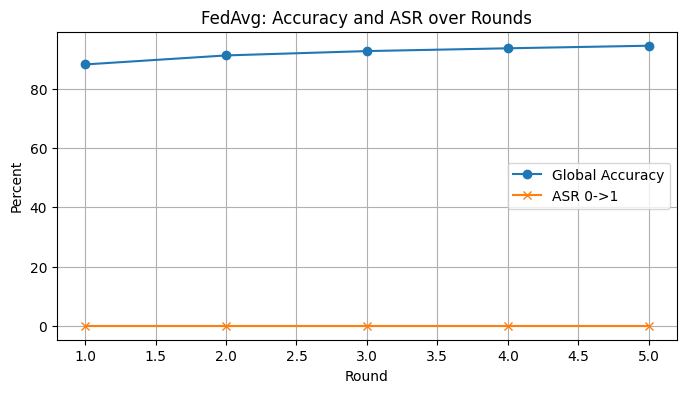

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(range(1, NUM_ROUNDS+1), [a*100 for a in acc_history], marker='o', label='Global Accuracy')
plt.plot(range(1, NUM_ROUNDS+1), [a*100 for a in asr_history], marker='x', label=f'ASR {source_label}->{target_label}')
plt.xlabel('Round')
plt.ylabel('Percent')
plt.title('FedAvg: Accuracy and ASR over Rounds')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from collections import Counter
# show label distribution per client
for i, loader in enumerate(client_loaders):
    labels = []
    for _, y in loader:
        labels.extend(y.tolist())
    c = Counter(labels)
    print(f"Client {i}: total={sum(c.values())}, label_counts={dict(c)}")


Client 0: total=6000, label_counts={6: 608, 2: 581, 4: 623, 0: 592, 5: 514, 8: 551, 3: 608, 1: 671, 7: 651, 9: 601}
Client 1: total=6000, label_counts={0: 614, 8: 576, 7: 628, 9: 592, 3: 620, 6: 600, 2: 595, 5: 534, 1: 680, 4: 561}
Client 2: total=6000, label_counts={8: 605, 4: 563, 1: 700, 5: 539, 3: 655, 7: 621, 2: 564, 0: 577, 9: 613, 6: 563}
Client 3: total=6000, label_counts={9: 605, 0: 598, 5: 557, 1: 681, 7: 589, 3: 604, 8: 560, 2: 607, 6: 599, 4: 600}
Client 4: total=6000, label_counts={7: 618, 3: 586, 9: 592, 5: 565, 4: 579, 1: 691, 6: 605, 0: 580, 2: 601, 8: 583}
Client 5: total=6000, label_counts={6: 592, 2: 594, 4: 581, 1: 690, 9: 621, 0: 573, 7: 614, 5: 521, 3: 617, 8: 597}
Client 6: total=6000, label_counts={8: 568, 5: 554, 4: 592, 2: 605, 3: 578, 6: 613, 7: 609, 9: 586, 1: 686, 0: 609}
Client 7: total=6000, label_counts={6: 568, 4: 556, 5: 540, 7: 638, 0: 586, 2: 615, 9: 592, 3: 621, 1: 671, 8: 613}
Client 8: total=6000, label_counts={0: 607, 8: 601, 3: 615, 6: 599, 7: 6

In [ ]:
# CELL A — Label-flip grid experiments
import numpy as np
import torch
import torch.nn.functional as F
import pandas as pd
import copy
from itertools import product
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Experiment config (tweak)
NUM_ROUNDS = 5
LOCAL_EPOCHS = 1
ATTACKER_LOCAL_EPOCHS = 5
lr = 0.01

# grid to try
attacker_fractions = [0.1, 0.3]   # e.g., 10% and 30% attackers
flip_modes = ["single", "full"]    # single: only source->target, full: y -> (y+1)%10
scale_options = [False, True]      # whether to scale malicious deltas
scale_factor = 5.0

# target/source for ASR when using "single"
source_label = 0
target_label = 1

# helpers (re-used)
def local_train_return_weights(model, trainloader, global_weights, local_epochs=1, lr=0.01, is_malicious=False, flip_mode="single"):
    set_weights(model, global_weights)
    model.to(device)
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for _ in range(local_epochs):
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            if is_malicious:
                if flip_mode == "single":
                    mask = (y == source_label)
                    if mask.any():
                        y[mask] = target_label
                else:  # full
                    y = (y + 1) % 10
            optimizer.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer.step()
    return get_weights(model), len(trainloader.dataset)

def scale_update(client_w, global_w, scale):
    scaled = []
    for cw, gw in zip(client_w, global_w):
        delta = cw - gw
        scaled.append(gw + scale * delta)
    return scaled

@torch.no_grad()
def compute_asr(model, src=0, tgt=1):
    model.to(device); model.eval()
    total_source = 0; source_to_target = 0
    for x, y in testloader:
        mask = (y == src)
        if not mask.any(): continue
        x_src = x[mask].to(device); y_src = y[mask].to(device)
        out = model(x_src); preds = out.argmax(dim=1)
        total_source += y_src.size(0)
        source_to_target += (preds == tgt).sum().item()
    return (source_to_target / total_source) if total_source > 0 else 0.0

def evaluate_global(model):
    model.to(device); model.eval()
    correct = 0; total = 0
    with torch.no_grad():
        for x,y in testloader:
            x,y = x.to(device), y.to(device)
            out = model(x); preds = out.argmax(dim=1)
            correct += (preds == y).sum().item(); total += x.size(0)
    return correct / total if total > 0 else 0.0

# Run grid
results = []
num_clients = len(client_loaders)
client_indices = list(range(num_clients))

for frac, flip_mode, scale in product(attacker_fractions, flip_modes, scale_options):
    k_attackers = max(1, int(round(frac * num_clients)))
    # choose first k_attackers clients as malicious (deterministic)
    malicious_ids = set(client_indices[:k_attackers])
    print(f"\nRunning config: frac={frac}, k={k_attackers}, flip_mode={flip_mode}, scale={scale}")
    # Initialize global model
    global_model = Net().to(device)
    global_weights = get_weights(global_model)
    acc_history = []; asr_history = []
    for rnd in range(1, NUM_ROUNDS+1):
        client_updates = []; client_ns = []
        for i, trainloader in enumerate(client_loaders):
            local_model = Net()
            is_mal = (i in malicious_ids)
            local_epochs = ATTACKER_LOCAL_EPOCHS if is_mal else LOCAL_EPOCHS
            w, n = local_train_return_weights(local_model, trainloader, global_weights,
                                              local_epochs=local_epochs, lr=lr, is_malicious=is_mal, flip_mode=flip_mode)
            if is_mal and scale:
                w = scale_update(w, global_weights, scale_factor)
            client_updates.append(w); client_ns.append(n)
        # FedAvg average
        total_n = sum(client_ns)
        avg_weights = []
        for li in range(len(client_updates[0])):
            accum = np.zeros(client_updates[0][li].shape, dtype=client_updates[0][li].dtype)
            for ci in range(len(client_updates)):
                accum += client_updates[ci][li] * (client_ns[ci] / total_n)
            avg_weights.append(accum)
        global_weights = avg_weights
        set_weights(global_model, global_weights)
        acc = evaluate_global(global_model)
        asr = compute_asr(global_model, src=source_label, tgt=target_label)
        acc_history.append(acc); asr_history.append(asr)
        print(f"Round {rnd} -> acc {acc*100:.2f}%, ASR {asr*100:.2f}%")
    results.append({
        "attacker_frac": frac,
        "k_attackers": k_attackers,
        "flip_mode": flip_mode,
        "scale": scale,
        "round_1_acc": acc_history[0],
        "round_final_acc": acc_history[-1],
        "round_1_asr": asr_history[0],
        "round_final_asr": asr_history[-1],
        "acc_series": acc_history,
        "asr_series": asr_history
    })

# Save summary CSV (flatten basic results)
df = pd.DataFrame([{
    "attacker_frac": r["attacker_frac"],
    "k_attackers": r["k_attackers"],
    "flip_mode": r["flip_mode"],
    "scale": r["scale"],
    "final_acc": r["round_final_acc"],
    "final_asr": r["round_final_asr"]
} for r in results])
df.to_csv("results_labelflip_summary.csv", index=False)
print("\nSaved results_labelflip_summary.csv")



Running config: frac=0.1, k=1, flip_mode=single, scale=False
Round 1 -> acc 89.38%, ASR 0.00%
Round 2 -> acc 92.28%, ASR 0.00%
Round 3 -> acc 93.66%, ASR 0.00%
Round 4 -> acc 94.82%, ASR 0.00%
Round 5 -> acc 95.40%, ASR 0.00%

Running config: frac=0.1, k=1, flip_mode=single, scale=True
Round 1 -> acc 83.34%, ASR 0.00%
Round 2 -> acc 89.87%, ASR 45.61%
Round 3 -> acc 94.19%, ASR 1.12%
Round 4 -> acc 91.49%, ASR 41.84%
Round 5 -> acc 95.81%, ASR 5.20%

Running config: frac=0.1, k=1, flip_mode=full, scale=False
Round 1 -> acc 89.27%, ASR 0.00%
Round 2 -> acc 91.38%, ASR 0.00%
Round 3 -> acc 93.08%, ASR 0.00%
Round 4 -> acc 94.15%, ASR 0.00%
Round 5 -> acc 94.93%, ASR 0.00%

Running config: frac=0.1, k=1, flip_mode=full, scale=True
Round 1 -> acc 59.16%, ASR 0.00%
Round 2 -> acc 73.96%, ASR 4.18%
Round 3 -> acc 80.02%, ASR 0.10%
Round 4 -> acc 87.25%, ASR 1.63%
Round 5 -> acc 84.43%, ASR 2.04%

Running config: frac=0.3, k=3, flip_mode=single, scale=False
Round 1 -> acc 87.65%, ASR 0.00%
R

In [ ]:
import pandas as pd
df = pd.read_csv("results_labelflip_summary.csv")
display(df)


,attacker_frac,k_attackers,flip_mode,scale,final_acc,final_asr
0,0.1,1,single,False,0.9540,0.000000
1,0.1,1,single,True,0.9581,0.052041
2,0.1,1,full,False,0.9493,0.000000
3,0.1,1,full,True,0.8443,0.020408
4,0.3,3,single,False,0.9612,0.003061
5,0.3,3,single,True,0.8439,0.902041
6,0.3,3,full,False,0.9172,0.002041
7,0.3,3,full,True,0.0500,0.993878


In [ ]:
# CELL B — Backdoor attack (visual trigger) experiment (paste & run)
import numpy as np
import torch
import torch.nn.functional as F
from copy import deepcopy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Config (tweak if you want)
NUM_ROUNDS = 5
LOCAL_EPOCHS = 1
ATTACKER_LOCAL_EPOCHS = 5
lr = 0.01
malicious_client_ids = {0, 1}   # attacker clients (change as needed)
target_label = 7                # the label attacker wants triggered inputs to be classified as
poison_frac = 0.2               # fraction of local mini-batch attacker poisons

# Trigger function: add a small white square in bottom-right of the image
def add_trigger_batch(x_batch, size=4, value=1.0):
    x = x_batch.clone()
    b, c, h, w = x.shape
    x[:, :, h-size:h, w-size:w] = value
    return x

# Build a triggered test set (trigger applied to all test images)
triggered_inputs = []
triggered_labels = []
for x, y in testloader:
    xt = add_trigger_batch(x, size=4, value=1.0)
    triggered_inputs.append(xt)
    triggered_labels.append(y)
triggered_X = torch.cat(triggered_inputs, dim=0)
triggered_Y = torch.cat(triggered_labels, dim=0)
print("Triggered test built:", triggered_X.shape, triggered_Y.shape)

# Local training for backdoor (attackers poison a fraction of their batches)
def local_train_backdoor(model, trainloader, global_weights, local_epochs=1, lr=0.01, is_malicious=False, poison_frac=0.2):
    set_weights(model, global_weights)
    model.to(device)
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for _ in range(local_epochs):
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            if is_malicious:
                B = x.size(0)
                k = max(1, int(round(poison_frac * B)))
                idx = torch.randperm(B)[:k]
                x[idx] = add_trigger_batch(x[idx], size=4, value=1.0)
                y[idx] = target_label
            optimizer.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer.step()
    return get_weights(model), len(trainloader.dataset)

@torch.no_grad()
def compute_asr_backdoor(model):
    model.to(device); model.eval()
    correct_target = 0; total = 0
    batch_size = 256
    for i in range(0, len(triggered_X), batch_size):
        xb = triggered_X[i:i+batch_size].to(device)
        out = model(xb)
        preds = out.argmax(dim=1)
        total += preds.size(0)
        correct_target += (preds == target_label).sum().item()
    return correct_target / total if total > 0 else 0.0

def evaluate_global(model):
    model.to(device); model.eval()
    correct = 0; total = 0
    with torch.no_grad():
        for x,y in testloader:
            x,y = x.to(device), y.to(device)
            out = model(x); preds = out.argmax(dim=1)
            correct += (preds == y).sum().item(); total += x.size(0)
    return correct / total if total > 0 else 0.0

# Run FedAvg with the backdoor attackers
global_model = Net().to(device)
global_weights = get_weights(global_model)

print("Starting backdoor experiment: attackers:", malicious_client_ids, "target_label:", target_label)
for rnd in range(1, NUM_ROUNDS+1):
    client_updates = []; client_ns = []
    for i, trainloader in enumerate(client_loaders):
        local_model = Net()
        is_mal = (i in malicious_client_ids)
        local_epochs = ATTACKER_LOCAL_EPOCHS if is_mal else LOCAL_EPOCHS
        w, n = local_train_backdoor(local_model, trainloader, global_weights,
                                    local_epochs=local_epochs, lr=lr, is_malicious=is_mal, poison_frac=poison_frac)
        client_updates.append(w); client_ns.append(n)
    # FedAvg average
    total_n = sum(client_ns)
    avg_weights = []
    for li in range(len(client_updates[0])):
        accum = np.zeros(client_updates[0][li].shape, dtype=client_updates[0][li].dtype)
        for ci in range(len(client_updates)):
            accum += client_updates[ci][li] * (client_ns[ci] / total_n)
        avg_weights.append(accum)
    global_weights = avg_weights
    set_weights(global_model, global_weights)

    acc = evaluate_global(global_model)
    asr_b = compute_asr_backdoor(global_model)
    print(f"Round {rnd} -> Global acc: {acc*100:.2f}%, Backdoor ASR -> target {target_label}: {asr_b*100:.2f}%")

print("Backdoor experiment finished.")


Triggered test built: torch.Size([10000, 1, 28, 28]) torch.Size([10000])
Starting backdoor experiment: attackers: {0, 1} target_label: 7
Round 1 -> Global acc: 90.64%, Backdoor ASR -> target 7: 13.19%
Round 2 -> Global acc: 92.23%, Backdoor ASR -> target 7: 14.19%
Round 3 -> Global acc: 94.59%, Backdoor ASR -> target 7: 21.19%
Round 4 -> Global acc: 95.45%, Backdoor ASR -> target 7: 24.06%
Round 5 -> Global acc: 95.86%, Backdoor ASR -> target 7: 32.22%
Backdoor experiment finished.


In [ ]:
# CELL C — Defenses: Trimmed Mean and Krum vs Baseline (backdoor scenario)
import numpy as np
import torch
import torch.nn.functional as F
from copy import deepcopy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Config (matches your last backdoor experiment) ----------
NUM_ROUNDS = 5
LOCAL_EPOCHS = 1
ATTACKER_LOCAL_EPOCHS = 5
lr = 0.01
malicious_client_ids = {0, 1}
target_label = 7
poison_frac = 0.2

# ---------- Aggregator functions ----------
def trimmed_mean_aggregate(client_updates, trim_ratio=0.2):
    n_clients = len(client_updates)
    trimmed = []
    for layer_idx in range(len(client_updates[0])):
        # stack per client for this layer
        stacked = np.stack([client_updates[c][layer_idx].reshape(-1) for c in range(n_clients)], axis=0)  # (n_clients, N)
        trim_count = int(np.floor(trim_ratio * n_clients))
        sorted_vals = np.sort(stacked, axis=0)
        if trim_count > 0:
            trimmed_vals = sorted_vals[trim_count: n_clients-trim_count, :]
        else:
            trimmed_vals = sorted_vals
        mean_vals = np.mean(trimmed_vals, axis=0)
        avg_layer = mean_vals.reshape(client_updates[0][layer_idx].shape)
        trimmed.append(avg_layer)
    return trimmed

def krum_aggregate(client_updates, f=1):
    n = len(client_updates)
    if n <= 2*f + 2:
        raise ValueError("Not enough clients for Krum with f={} (need n > 2f+2)".format(f))
    # flatten
    flat = [np.concatenate([layer.reshape(-1) for layer in client_updates[c]]) for c in range(n)]
    dists = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            d = np.sum((flat[i] - flat[j])**2)
            dists[i,j] = d; dists[j,i] = d
    scores = []
    for i in range(n):
        sorted_d = np.sort(dists[i])
        nb_count = n - f - 2
        # sum of smallest nb_count distances (exclude its own zero at sorted_d[0])
        score = np.sum(sorted_d[1:1+nb_count])
        scores.append(score)
    winner = int(np.argmin(scores))
    # return the chosen client's update (Krum selects a single update)
    return client_updates[winner]

# ---------- Backdoor local training used earlier ----------
def add_trigger_batch(x_batch, size=4, value=1.0):
    x = x_batch.clone()
    b, c, h, w = x.shape
    x[:, :, h-size:h, w-size:w] = value
    return x

def local_train_backdoor(model, trainloader, global_weights, local_epochs=1, lr=0.01, is_malicious=False, poison_frac=0.2):
    set_weights(model, global_weights)
    model.to(device)
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for _ in range(local_epochs):
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            if is_malicious:
                B = x.size(0)
                k = max(1, int(round(poison_frac * B)))
                idx = torch.randperm(B)[:k]
                x[idx] = add_trigger_batch(x[idx], size=4, value=1.0)
                y[idx] = target_label
            optimizer.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer.step()
    return get_weights(model), len(trainloader.dataset)

@torch.no_grad()
def compute_asr_backdoor(model):
    model.to(device); model.eval()
    correct_target = 0; total = 0
    batch_size = 256
    for i in range(0, len(triggered_X), batch_size):
        xb = triggered_X[i:i+batch_size].to(device)
        out = model(xb)
        preds = out.argmax(dim=1)
        total += preds.size(0)
        correct_target += (preds == target_label).sum().item()
    return correct_target / total if total > 0 else 0.0

def evaluate_global(model):
    model.to(device); model.eval()
    correct = 0; total = 0
    with torch.no_grad():
        for x,y in testloader:
            x,y = x.to(device), y.to(device)
            out = model(x); preds = out.argmax(dim=1)
            correct += (preds == y).sum().item(); total += x.size(0)
    return correct / total if total > 0 else 0.0

# ---------- Helper to run one experiment with chosen aggregator ----------
def run_backdoor_with_aggregator(aggregator_name="fedavg", trim_ratio=0.2, krum_f=1):
    print("\n=== Running with aggregator:", aggregator_name, "===")
    global_model = Net().to(device)
    global_weights = get_weights(global_model)
    acc_history = []; asr_history = []
    for rnd in range(1, NUM_ROUNDS+1):
        client_updates = []; client_ns = []
        for i, trainloader in enumerate(client_loaders):
            local_model = Net()
            is_mal = (i in malicious_client_ids)
            local_epochs = ATTACKER_LOCAL_EPOCHS if is_mal else LOCAL_EPOCHS
            w, n = local_train_backdoor(local_model, trainloader, global_weights,
                                        local_epochs=local_epochs, lr=lr, is_malicious=is_mal, poison_frac=poison_frac)
            client_updates.append(w); client_ns.append(n)
        # Aggregate
        if aggregator_name == "fedavg":
            total_n = sum(client_ns)
            avg_weights = []
            for li in range(len(client_updates[0])):
                accum = np.zeros(client_updates[0][li].shape, dtype=client_updates[0][li].dtype)
                for ci in range(len(client_updates)):
                    accum += client_updates[ci][li] * (client_ns[ci] / total_n)
                avg_weights.append(accum)
        elif aggregator_name == "trimmed_mean":
            avg_weights = trimmed_mean_aggregate(client_updates, trim_ratio=trim_ratio)
        elif aggregator_name == "krum":
            avg_weights = krum_aggregate(client_updates, f=krum_f)
        else:
            raise ValueError("Unknown aggregator")
        global_weights = avg_weights
        set_weights(global_model, global_weights)
        acc = evaluate_global(global_model)
        asr_b = compute_asr_backdoor(global_model)
        acc_history.append(acc); asr_history.append(asr_b)
        print(f"Round {rnd} -> acc: {acc*100:.2f}%, Backdoor ASR: {asr_b*100:.2f}%")
    return acc_history, asr_history

# ---------- Run baseline, trimmed mean, and krum ----------
# Ensure triggered_X / triggered_Y exist from your previous Cell B run (they should)
# If not present, you must rebuild triggered_X as in Cell B before running this cell.
try:
    _ = triggered_X.shape
except NameError:
    raise RuntimeError("triggered_X not found. Run Cell B (backdoor) first to build triggered test set.")

# FedAvg baseline
acc_b, asr_b = run_backdoor_with_aggregator("fedavg")

# Trimmed Mean
acc_t, asr_t = run_backdoor_with_aggregator("trimmed_mean", trim_ratio=0.2)

# Krum (choose f = number of suspected Byzantine clients; here f=2 for 2 attackers)
acc_k, asr_k = run_backdoor_with_aggregator("krum", krum_f=2)

print("\nFinished defense experiments. Summary (final round):")
print(f"FedAvg -> acc {acc_b[-1]*100:.2f}%, ASR {asr_b[-1]*100:.2f}%")
print(f"TrimmedMean -> acc {acc_t[-1]*100:.2f}%, ASR {asr_t[-1]*100:.2f}%")
print(f"Krum -> acc {acc_k[-1]*100:.2f}%, ASR {asr_k[-1]*100:.2f}%")



=== Running with aggregator: fedavg ===
Round 1 -> acc: 90.11%, Backdoor ASR: 11.22%
Round 2 -> acc: 92.48%, Backdoor ASR: 13.22%
Round 3 -> acc: 94.28%, Backdoor ASR: 18.56%
Round 4 -> acc: 95.22%, Backdoor ASR: 28.56%
Round 5 -> acc: 95.97%, Backdoor ASR: 36.90%

=== Running with aggregator: trimmed_mean ===
Round 1 -> acc: 90.01%, Backdoor ASR: 9.92%
Round 2 -> acc: 92.42%, Backdoor ASR: 10.06%
Round 3 -> acc: 93.83%, Backdoor ASR: 10.37%
Round 4 -> acc: 94.47%, Backdoor ASR: 10.08%
Round 5 -> acc: 95.25%, Backdoor ASR: 10.13%

=== Running with aggregator: krum ===
Round 1 -> acc: 84.98%, Backdoor ASR: 8.38%
Round 2 -> acc: 87.50%, Backdoor ASR: 9.72%
Round 3 -> acc: 90.37%, Backdoor ASR: 9.47%
Round 4 -> acc: 92.50%, Backdoor ASR: 9.73%
Round 5 -> acc: 91.75%, Backdoor ASR: 9.87%

Finished defense experiments. Summary (final round):
FedAvg -> acc 95.97%, ASR 36.90%
TrimmedMean -> acc 95.25%, ASR 10.13%
Krum -> acc 91.75%, ASR 9.87%


In [ ]:
# Trim sweep + simple FoolsGold aggregator (paste-run)
import numpy as np
import torch, torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.metrics.pairwise import cosine_similarity

# Experiment config (matches your earlier backdoor run)
NUM_ROUNDS = 5
LOCAL_EPOCHS = 1
ATTACKER_LOCAL_EPOCHS = 5
lr = 0.01
malicious_client_ids = {0,1}
target_label = 7
poison_frac = 0.2

# Use same local_train_backdoor from earlier (redefine if necessary)
def add_trigger_batch(x_batch, size=4, value=1.0):
    x = x_batch.clone()
    b, c, h, w = x.shape
    x[:, :, h-size:h, w-size:w] = value
    return x

def local_train_backdoor(model, trainloader, global_weights, local_epochs=1, lr=0.01, is_malicious=False, poison_frac=0.2):
    set_weights(model, global_weights)
    model.to(device)
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for _ in range(local_epochs):
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            if is_malicious:
                B = x.size(0)
                k = max(1, int(round(poison_frac * B)))
                idx = torch.randperm(B)[:k]
                x[idx] = add_trigger_batch(x[idx], size=4, value=1.0)
                y[idx] = target_label
            optimizer.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer.step()
    return get_weights(model), len(trainloader.dataset)

# Evaluate helpers
@torch.no_grad()
def compute_asr_backdoor(model):
    model.to(device); model.eval()
    correct_target = 0; total = 0
    batch_size = 256
    for i in range(0, len(triggered_X), batch_size):
        xb = triggered_X[i:i+batch_size].to(device)
        out = model(xb)
        preds = out.argmax(dim=1)
        total += preds.size(0)
        correct_target += (preds == target_label).sum().item()
    return correct_target / total if total > 0 else 0.0

def evaluate_global(model):
    model.to(device); model.eval()
    correct = 0; total = 0
    with torch.no_grad():
        for x,y in testloader:
            x,y = x.to(device), y.to(device)
            out = model(x); preds = out.argmax(dim=1)
            correct += (preds == y).sum().item(); total += x.size(0)
    return correct/total if total>0 else 0.0

# Aggregators
def trimmed_mean_aggregate(client_updates, trim_ratio=0.2):
    n_clients = len(client_updates)
    trimmed = []
    for layer_idx in range(len(client_updates[0])):
        stacked = np.stack([client_updates[c][layer_idx].reshape(-1) for c in range(n_clients)], axis=0)
        trim_count = int(np.floor(trim_ratio * n_clients))
        sorted_vals = np.sort(stacked, axis=0)
        if trim_count > 0:
            trimmed_vals = sorted_vals[trim_count: n_clients-trim_count, :]
        else:
            trimmed_vals = sorted_vals
        mean_vals = np.mean(trimmed_vals, axis=0)
        trimmed.append(mean_vals.reshape(client_updates[0][layer_idx].shape))
    return trimmed

def fools_gold_weights(client_updates, global_weights, eps=1e-8):
    # client_updates: list of client weight lists (numpy arrays)
    n = len(client_updates)
    # build flatten delta vectors (client_w - global_w)
    deltas = []
    for c in range(n):
        flat = np.concatenate([ (client_updates[c][i] - global_weights[i]).reshape(-1) for i in range(len(global_weights)) ])
        deltas.append(flat)
    deltas = np.stack(deltas, axis=0)  # shape (n, D)
    # compute cosine similarity matrix (n x n)
    sims = cosine_similarity(deltas)  # values in [-1,1], diagonal=1
    np.fill_diagonal(sims, 0.0)
    # for each client, take maximum similarity to any other client
    max_sim = sims.max(axis=1)  # shape (n,)
    # derive weight = 1 - max_sim (so high-sim => low weight)
    raw_w = 1.0 - max_sim
    # clip negative to small positive
    raw_w = np.clip(raw_w, a_min=eps, a_max=None)
    # normalize to sum=1
    norm_w = raw_w / raw_w.sum()
    return norm_w  # length n, sum=1

def aggregate_with_weights(client_updates, weights):
    # weights: numpy array shape (n,)
    n = len(client_updates)
    avg = []
    for layer_idx in range(len(client_updates[0])):
        accum = np.zeros(client_updates[0][layer_idx].shape, dtype=client_updates[0][layer_idx].dtype)
        for i in range(n):
            accum += client_updates[i][layer_idx] * weights[i]
        avg.append(accum)
    return avg

# Run baseline (FedAvg) for reference
print("Running baseline FedAvg (for comparison)...")
global_model = Net().to(device); global_weights = get_weights(global_model)
for rnd in range(1, NUM_ROUNDS+1):
    client_updates = []; client_ns = []
    for i, trainloader in enumerate(client_loaders):
        local_model = Net()
        is_mal = (i in malicious_client_ids)
        local_epochs = ATTACKER_LOCAL_EPOCHS if is_mal else LOCAL_EPOCHS
        w, n = local_train_backdoor(local_model, trainloader, global_weights,
                                    local_epochs=local_epochs, lr=lr, is_malicious=is_mal, poison_frac=poison_frac)
        client_updates.append(w); client_ns.append(n)
    # FedAvg average
    total_n = sum(client_ns)
    avg = []
    for li in range(len(client_updates[0])):
        accum = np.zeros(client_updates[0][li].shape, dtype=client_updates[0][li].dtype)
        for ci in range(len(client_updates)):
            accum += client_updates[ci][li] * (client_ns[ci]/total_n)
        avg.append(accum)
    global_weights = avg; set_weights(global_model, global_weights)
    print(f"Round {rnd} -> acc {evaluate_global(global_model)*100:.2f} %, ASR {compute_asr_backdoor(global_model)*100:.2f}%")

# Trimmed mean sweep
trim_values = [0.05, 0.1, 0.2, 0.3]
trim_results = {}
for trim in trim_values:
    print("\nTrim ratio:", trim)
    global_model = Net().to(device); global_weights = get_weights(global_model)
    for rnd in range(1, NUM_ROUNDS+1):
        client_updates = []; client_ns = []
        for i, trainloader in enumerate(client_loaders):
            local_model = Net()
            is_mal = (i in malicious_client_ids)
            local_epochs = ATTACKER_LOCAL_EPOCHS if is_mal else LOCAL_EPOCHS
            w, n = local_train_backdoor(local_model, trainloader, global_weights,
                                        local_epochs=local_epochs, lr=lr, is_malicious=is_mal, poison_frac=poison_frac)
            client_updates.append(w); client_ns.append(n)
        avg = trimmed_mean_aggregate(client_updates, trim_ratio=trim)
        global_weights = avg; set_weights(global_model, global_weights)
        print(f"Round {rnd} -> acc {evaluate_global(global_model)*100:.2f} %, ASR {compute_asr_backdoor(global_model)*100:.2f}%")
    trim_results[trim] = (evaluate_global(global_model), compute_asr_backdoor(global_model))

# FoolsGold-style aggregator (simple round-local version)
print("\nRunning FoolsGold-style round-local aggregator...")
global_model = Net().to(device); global_weights = get_weights(global_model)
for rnd in range(1, NUM_ROUNDS+1):
    client_updates = []; client_ns = []
    for i, trainloader in enumerate(client_loaders):
        local_model = Net()
        is_mal = (i in malicious_client_ids)
        local_epochs = ATTACKER_LOCAL_EPOCHS if is_mal else LOCAL_EPOCHS
        w, n = local_train_backdoor(local_model, trainloader, global_weights,
                                    local_epochs=local_epochs, lr=lr, is_malicious=is_mal, poison_frac=poison_frac)
        client_updates.append(w); client_ns.append(n)
    # compute FG weights
    wgts = fools_gold_weights(client_updates, global_weights)
    avg = aggregate_with_weights(client_updates, wgts)
    global_weights = avg; set_weights(global_model, global_weights)
    print(f"Round {rnd} -> acc {evaluate_global(global_model)*100:.2f} %, ASR {compute_asr_backdoor(global_model)*100:.2f}%")

print("\nTrim sweep results (final):")
for t,r in trim_results.items():
    print(f"trim {t} -> acc {r[0]*100:.2f}%, ASR {r[1]*100:.2f}%")


Running baseline FedAvg (for comparison)...
Round 1 -> acc 88.40 %, ASR 11.48%
Round 2 -> acc 92.50 %, ASR 15.09%
Round 3 -> acc 94.25 %, ASR 17.58%
Round 4 -> acc 95.24 %, ASR 27.28%
Round 5 -> acc 95.68 %, ASR 37.39%

Trim ratio: 0.05
Round 1 -> acc 89.75 %, ASR 12.30%
Round 2 -> acc 92.54 %, ASR 15.17%
Round 3 -> acc 94.27 %, ASR 15.37%
Round 4 -> acc 95.41 %, ASR 22.68%
Round 5 -> acc 96.11 %, ASR 38.67%

Trim ratio: 0.1
Round 1 -> acc 89.64 %, ASR 10.62%
Round 2 -> acc 92.46 %, ASR 11.77%
Round 3 -> acc 94.07 %, ASR 13.67%
Round 4 -> acc 94.73 %, ASR 13.28%
Round 5 -> acc 95.55 %, ASR 17.26%

Trim ratio: 0.2
Round 1 -> acc 88.21 %, ASR 11.53%
Round 2 -> acc 91.83 %, ASR 9.86%
Round 3 -> acc 93.28 %, ASR 9.98%
Round 4 -> acc 94.36 %, ASR 10.04%
Round 5 -> acc 95.00 %, ASR 10.29%

Trim ratio: 0.3
Round 1 -> acc 88.74 %, ASR 9.78%
Round 2 -> acc 92.14 %, ASR 9.70%
Round 3 -> acc 93.34 %, ASR 10.29%
Round 4 -> acc 93.87 %, ASR 10.13%
Round 5 -> acc 94.90 %, ASR 9.93%

Running FoolsGol


=== Running fedavg ===
[fedavg] Round 1: acc 90.46%, ASR 10.88%
[fedavg] Round 2: acc 93.17%, ASR 13.46%
[fedavg] Round 3: acc 94.74%, ASR 19.60%
[fedavg] Round 4: acc 95.34%, ASR 18.94%
[fedavg] Round 5: acc 95.71%, ASR 29.01%

=== Running trimmed_mean ===
[trimmed_mean] Round 1: acc 89.61%, ASR 10.30%
[trimmed_mean] Round 2: acc 92.11%, ASR 9.52%
[trimmed_mean] Round 3: acc 93.79%, ASR 10.14%
[trimmed_mean] Round 4: acc 94.31%, ASR 10.66%
[trimmed_mean] Round 5: acc 95.16%, ASR 9.99%

=== Running krum ===
[krum] Round 1: acc 81.78%, ASR 16.78%
[krum] Round 2: acc 90.20%, ASR 9.75%
[krum] Round 3: acc 92.01%, ASR 9.69%
[krum] Round 4: acc 92.49%, ASR 9.93%
[krum] Round 5: acc 93.62%, ASR 10.03%


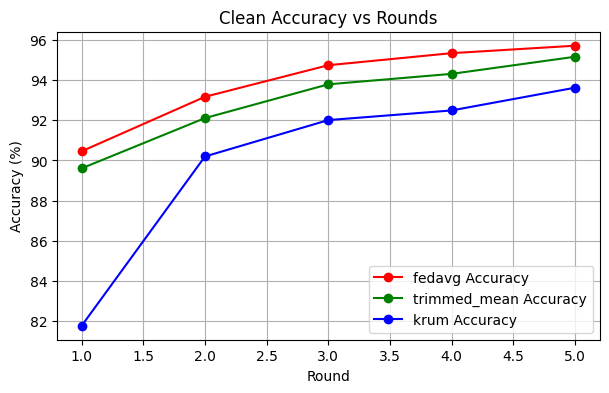

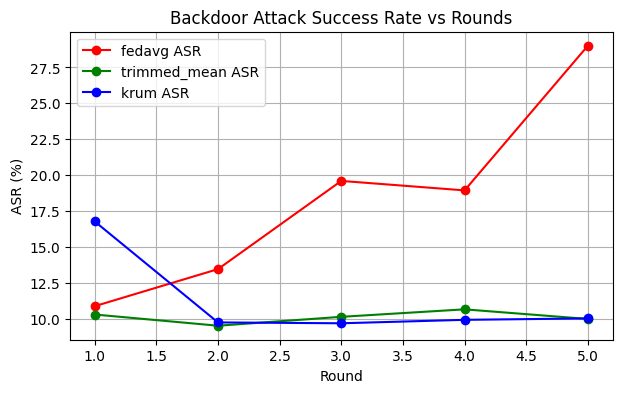

In [ ]:
# === Plot Accuracy & ASR vs Rounds for FedAvg, TrimmedMean(0.2), and Krum ===
import numpy as np
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Helper functions reused ---
@torch.no_grad()
def compute_asr_backdoor(model):
    model.to(device); model.eval()
    correct_target, total = 0, 0
    batch_size = 256
    for i in range(0, len(triggered_X), batch_size):
        xb = triggered_X[i:i+batch_size].to(device)
        preds = model(xb).argmax(dim=1)
        total += preds.size(0)
        correct_target += (preds == target_label).sum().item()
    return correct_target / total if total > 0 else 0.0

def evaluate_global(model):
    model.to(device); model.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += x.size(0)
    return correct / total

# --- Aggregators ---
def fedavg_aggregate(client_updates, client_ns):
    total_n = sum(client_ns)
    avg = []
    for li in range(len(client_updates[0])):
        accum = np.zeros_like(client_updates[0][li])
        for ci in range(len(client_updates)):
            accum += client_updates[ci][li] * (client_ns[ci]/total_n)
        avg.append(accum)
    return avg

def trimmed_mean_aggregate(client_updates, trim_ratio=0.2):
    n = len(client_updates)
    trimmed = []
    for li in range(len(client_updates[0])):
        stacked = np.stack([client_updates[c][li].reshape(-1) for c in range(n)], axis=0)
        trim = int(np.floor(trim_ratio*n))
        sorted_vals = np.sort(stacked, axis=0)
        kept = sorted_vals[trim:n-trim, :] if trim>0 else sorted_vals
        mean_vals = np.mean(kept, axis=0)
        trimmed.append(mean_vals.reshape(client_updates[0][li].shape))
    return trimmed

def krum_aggregate(client_updates, f=2):
    n = len(client_updates)
    flats = [np.concatenate([l.ravel() for l in w]) for w in client_updates]
    dmat = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            d = np.sum((flats[i]-flats[j])**2)
            dmat[i,j]=dmat[j,i]=d
    scores=[]
    for i in range(n):
        closest = np.sort(dmat[i])[:n-f-1]
        scores.append(np.sum(closest))
    winner = np.argmin(scores)
    return client_updates[winner]

# --- Run and record results for 3 aggregators ---
def run_experiment(agg_name, trim_ratio=0.2):
    global_model = Net().to(device)
    global_weights = get_weights(global_model)
    acc_hist, asr_hist = [], []
    for rnd in range(1,6):
        client_updates, client_ns = [], []
        for i, trainloader in enumerate(client_loaders):
            local_model = Net()
            is_mal = (i in malicious_client_ids)
            local_epochs = ATTACKER_LOCAL_EPOCHS if is_mal else LOCAL_EPOCHS
            w, n = local_train_backdoor(local_model, trainloader, global_weights,
                                        local_epochs=local_epochs, lr=lr,
                                        is_malicious=is_mal, poison_frac=poison_frac)
            client_updates.append(w); client_ns.append(n)
        if agg_name=="fedavg":
            global_weights = fedavg_aggregate(client_updates, client_ns)
        elif agg_name=="trimmed_mean":
            global_weights = trimmed_mean_aggregate(client_updates, trim_ratio)
        elif agg_name=="krum":
            global_weights = krum_aggregate(client_updates, f=2)
        set_weights(global_model, global_weights)
        acc = evaluate_global(global_model)
        asr = compute_asr_backdoor(global_model)
        acc_hist.append(acc); asr_hist.append(asr)
        print(f"[{agg_name}] Round {rnd}: acc {acc*100:.2f}%, ASR {asr*100:.2f}%")
    return np.array(acc_hist), np.array(asr_hist)

histories = {}
for name in ["fedavg","trimmed_mean","krum"]:
    print(f"\n=== Running {name} ===")
    histories[name] = run_experiment(name, trim_ratio=0.2 if name=="trimmed_mean" else None)

# --- Plot ---
rounds = np.arange(1,6)
plt.figure(figsize=(7,4))
for name,c in zip(histories.keys(),["r","g","b"]):
    plt.plot(rounds, histories[name][0]*100, marker="o", label=f"{name} Accuracy", color=c)
plt.xlabel("Round"); plt.ylabel("Accuracy (%)"); plt.title("Clean Accuracy vs Rounds")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(7,4))
for name,c in zip(histories.keys(),["r","g","b"]):
    plt.plot(rounds, histories[name][1]*100, marker="o", label=f"{name} ASR", color=c)
plt.xlabel("Round"); plt.ylabel("ASR (%)"); plt.title("Backdoor Attack Success Rate vs Rounds")
plt.legend(); plt.grid(True); plt.show()
